In [1]:
import os
import pickle
import pandas as pd
import ujson as json
import matplotlib.pyplot as plt
import seaborn as sns

from collections import OrderedDict
import numpy as np
from functools import partial
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
PATH_TO_DATA = './data/'
SEED = 17

In [3]:
train = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_features.csv'), index_col='match_id_hash')
target = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_targets.csv'), index_col='match_id_hash')
test = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_features.csv'), index_col='match_id_hash')

target['radiant_win'] = target['radiant_win'].map({True: 1, False: 0})
train = pd.concat([train, target['radiant_win']], axis=1)

In [4]:
target.head()

,game_time,radiant_win,duration,time_remaining,next_roshan_team
match_id_hash,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,0,992,837,NaN
b9c57c450ce74a2af79c9ce96fac144d,658,1,1154,496,NaN
6db558535151ea18ca70a6892197db41,21,1,1503,1482,Radiant
46a0ddce8f7ed2a8d9bd5edcbb925682,576,1,1952,1376,NaN
b1b35ff97723d9b7ade1c9c3cf48f770,453,0,2001,1548,NaN


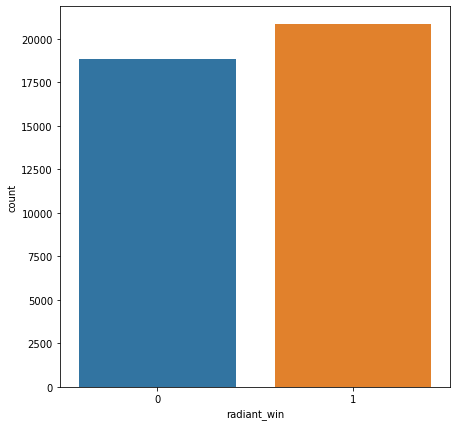

In [5]:
plt.figure(figsize=(7, 7))
sns.countplot(x="radiant_win", data=target);

In [6]:
train.shape

(39675, 246)

In [7]:
def countplot(df, x, title='foo'):
    value_counts = df[x].value_counts()
    plt.figure(figsize=(16, 6))
    sns.countplot(x=x, data=df, order=value_counts.index).set_title(title)
    return value_counts

22    31762
4      3564
23     2546
3      1200
2       408
5       188
12        5
16        2
Name: game_mode, dtype: int64


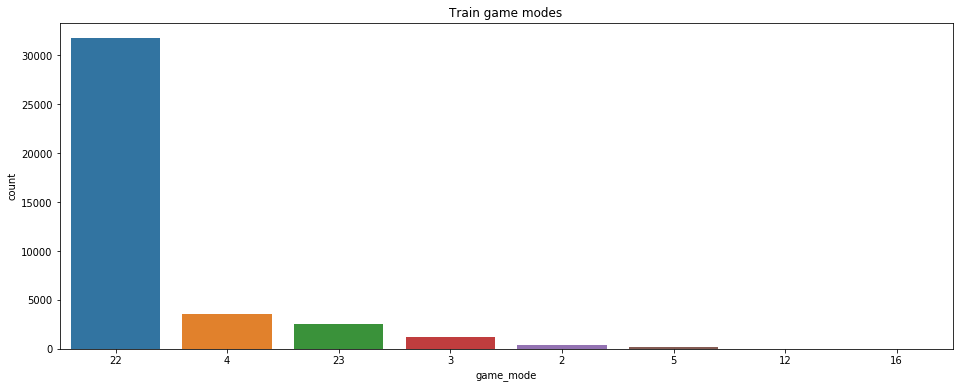

In [8]:
print(countplot(train, 'game_mode', 'Train game modes'))

22    8289
4      680
23     629
3      337
2       34
5       28
12       3
Name: game_mode, dtype: int64


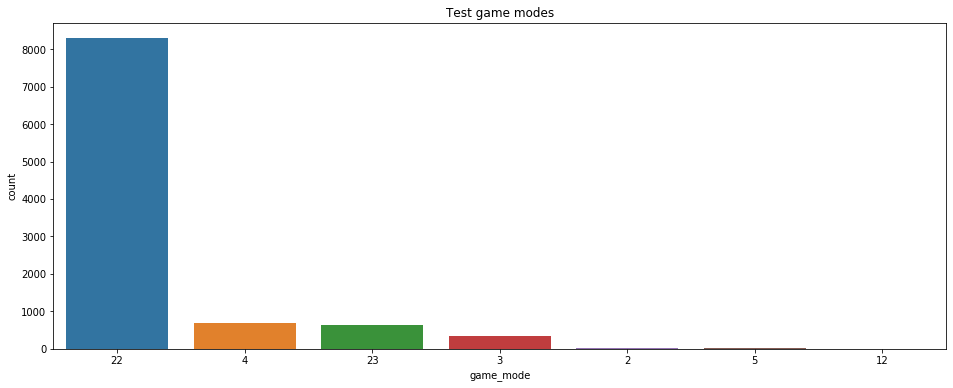

In [9]:
print(countplot(test, 'game_mode', 'Test game modes'))

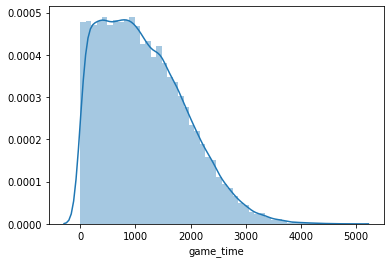

In [10]:
sns.distplot(train['game_time']);

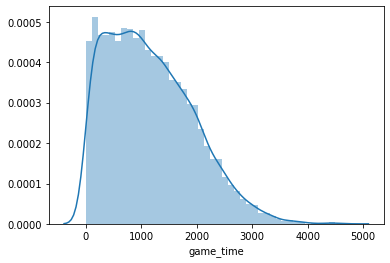

In [11]:
sns.distplot(test['game_time']);

In [12]:
train.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed,radiant_win
match_id_hash,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,22,7,1,11,11,0,0,0,0,...,0,0,0,0,0.00,0,0,0,0,0
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0,0,0,0,0.00,0,0,0,0,1
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0,0,0,0,0.00,0,0,0,0,1
46a0ddce8f7ed2a8d9bd5edcbb925682,576,22,7,1,4,14,1,0,3,1,...,3,1,3,0,0.00,0,0,2,0,1
b1b35ff97723d9b7ade1c9c3cf48f770,453,22,7,1,3,42,0,1,1,0,...,2,1,2,0,0.25,0,0,0,0,0


0    38610
1      968
2       88
3        9
Name: r1_roshans_killed, dtype: int64


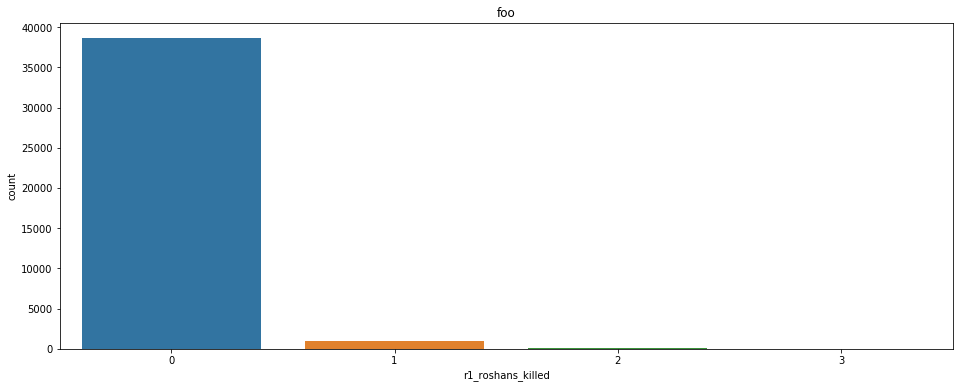

In [13]:
print(countplot(train, 'r1_roshans_killed'))

In [14]:
def read_matches(matches_file, size=None):
    with open(os.path.join(PATH_TO_DATA, matches_file)) as f:
        count = 0
        for line in f:
            if size is not None and count >= size:
                return
            count += 1
            yield json.loads(line)

In [15]:
match = None
len_times = 0
for m in read_matches('test_matches.jsonl'):
    if len(m['players'][0]['times']) > len_times:
        len_times = len(m['players'][0]['times'])
        match = m

In [16]:
r = match['players'][:5]
d = match['players'][5:]

In [17]:
r[0].keys()

dict_keys(['player_slot', 'hero_id', 'hero_name', 'account_id_hash', 'ability_upgrades', 'obs_placed', 'sen_placed', 'creeps_stacked', 'camps_stacked', 'rune_pickups', 'firstblood_claimed', 'teamfight_participation', 'towers_killed', 'roshans_killed', 'observers_placed', 'stuns', 'max_hero_hit', 'times', 'gold_t', 'lh_t', 'dn_t', 'xp_t', 'obs_log', 'sen_log', 'obs_left_log', 'sen_left_log', 'purchase_log', 'kills_log', 'buyback_log', 'runes_log', 'obs', 'sen', 'actions', 'pings', 'purchase', 'gold_reasons', 'xp_reasons', 'killed', 'item_uses', 'ability_uses', 'hero_hits', 'damage', 'damage_taken', 'damage_inflictor', 'runes', 'killed_by', 'kill_streaks', 'multi_kills', 'life_state', 'healing', 'damage_inflictor_received', 'randomed', 'pred_vict', 'gold', 'lh', 'xp', 'x', 'y', 'hero_inventory', 'hero_stash', 'health', 'max_health', 'max_mana', 'level', 'kills', 'deaths', 'assists', 'denies', 'nearby_creep_death_count'])

In [51]:
d[0]['life_state']

{'0': 7820, '1': 84, '2': 1502}

In [47]:
match['game_time']

4703

In [45]:

for i in range(0, 5):
    print(d[i]['kill_streaks'])
    
print('='*10)
      
for i in range(0, 5):
    print(r[i]['kill_streaks'])

{}
{}
{'3': 2, '4': 1, '5': 1, '6': 1, '7': 1, '8': 1}
{}
{'3': 2, '4': 2, '5': 2, '6': 1}
{'3': 1}
{'3': 4, '4': 2, '5': 2, '6': 1, '7': 1, '8': 1}
{}
{'3': 1}
{'3': 3, '4': 1, '5': 1, '6': 1, '7': 1}
